<a href="https://colab.research.google.com/github/Karthika506/Familial_melanoma/blob/main/Familial_melanoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_dataset(data_dir):
  images = []
  # masks = []
  for filename in os.listdir(data_dir):
    if filename.endswith('.jpg'):
      image_path = os.path.join(data_dir, filename)
      image = cv2.imread(image_path)
      images.append(image)

      # #masking the image......

      # #........
      # mask_filename = filename.replace('.jpg', '_mask.jpg')
      # mask_path = os.path.join(data_dir, mask_filename)
      # mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      # masks.append(mask)
  return np.array(images)

def generate_mask(image_path,threshold):
  image = cv2.imread(image_path)
  grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, binary_mask = cv2.threshold(grayscale, threshold, 255, cv2.THRESH_BINARY)
  inverted_mask = cv2.bitwise_not(binary_mask)
  return inverted_mask

def generate_mask_dataset(data_dir, threshold):
  image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
  masks = []
  for image_file in image_files:
    image_path = os.path.join(data_dir, image_file)
    mask = generate_mask(image_path, threshold)
    masks.append(mask)
  return np.array(masks)

def preprocess_data(images,masks):
  images = images.astype(np.float32) / 255.0
  masks = np.expand_dims(masks, axis=-1)
  return images, masks

data_dir = '/content/drive/MyDrive/melanoma'
threshold_value = 128
images = load_dataset(data_dir)
masks = generate_mask_dataset(data_dir, threshold_value)

images, masks = preprocess_data(images, masks)

In [4]:
print(masks)

[[[[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  ...

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]]


 [[[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  ...

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]

  [[255]
   [255]
   [255]
   ...
   [255]
   [255]
   [255]]]


 [[[255]
   [255]
   [255]
   ...
   [  0]
   [  0]
   [  0]]

  [[255]
   [255]
   [255]
   ...
   [  0]
   [  0]
   [  0]]

  [[255]
   [255]
   [255]
   ...
   [  0]
   [  0]
   [  0]]

  ...

  [[  0]
   [  0]
   [  0]
   

In [5]:
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=10)

In [6]:
import tensorflow as tf

def unet_model(input_shape):
  inputs = Input(input_shape)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
  up1 = UpSampling2D(size=(2, 2))(conv3)
  up1 = tf.image.resize(up1, (conv2.shape[1], conv2.shape[2]))  # Resize up1 to match conv2 shape

  concat1 = concatenate([conv2, up1], axis=-1)
  conv4 = Conv2D(128, 3, activation='relu', padding='same')(concat1)
  conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
  up2 = UpSampling2D(size=(2, 2))(conv4)

  concat2 = concatenate([conv1, up2], axis=-1)
  conv5 = Conv2D(64, 3, activation='relu', padding='same')(concat2)
  conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

  outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

  model = Model(inputs=inputs, outputs=outputs)
  return model


input_shape = train_images[0].shape
model = unet_model(input_shape)

model.compile(optimizer = Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
history = model.fit(train_images, train_masks, batch_size = 8, epochs = 10, validation_data = (val_images, val_masks))

Epoch 1/10
19/19 [==============================] - 92s 3s/step - loss: -2696501248.0000 - accuracy: 1.0395e-04 - val_loss: -53925179392.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
19/19 [==============================] - 28s 2s/step - loss: -57042433736704.0000 - accuracy: 0.0000e+00 - val_loss: -529596579577856.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
19/19 [==============================] - 28s 1s/step - loss: -41987587400794112.0000 - accuracy: 0.0000e+00 - val_loss: -252103344640753664.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
19/19 [==============================] - 28s 1s/step - loss: -5150025603084189696.0000 - accuracy: 0.0000e+00 - val_loss: -25881577929056452608.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
19/19 [==============================] - 27s 1s/step - loss: nan - accuracy: 0.2709 - val_loss: nan - val_accuracy: 0.7415
Epoch 6/10
19/19 [==============================] - 26s 1s/step - loss: nan - accuracy: 0.7352 - val_loss: nan - val_accuracy: 0.7415
Epoch 7/10
19/19

In [8]:
sample_image = val_images[0]
sample_mask = val_masks[0]

segmentation_mask = model.predict(np.expand_dims(sample_image, axis = 0))
segmentation_mask = np.squeeze(segmentation_mask)

threshold = 0.5
binary_mask = (segmentation_mask > threshold).astype(np.uint8)

1/1 [==============================] - 2s 2s/step


In [ ]:
binary_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

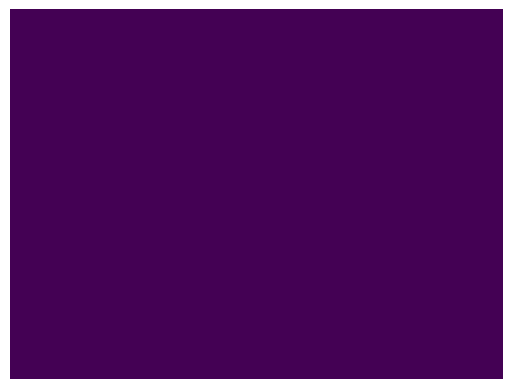

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have an array named 'image_array'
plt.imshow(binary_mask)
plt.axis('off')  # Remove axis ticks and labels
plt.show()

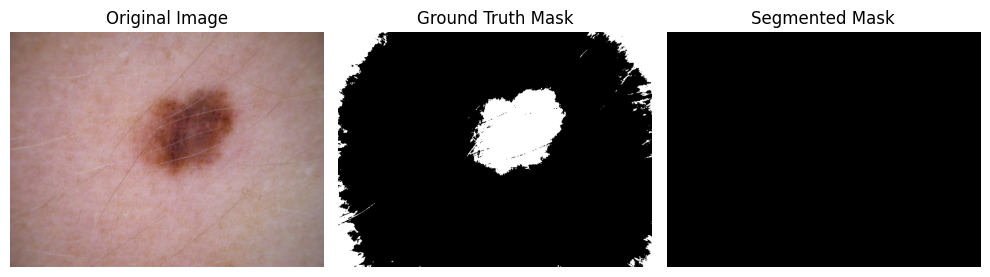

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(sample_mask), cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_mask, cmap='gray')
plt.title('Segmented Mask')
plt.axis('off')

plt.tight_layout()
plt.show()